In [60]:
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import accuracy_score

In [2]:
data = pl.read_csv("Vocational.csv")

In [3]:
df = data.drop('ind')

In [4]:
df.head()

treatment,age,score,gender,experience,previous_exp,distance_majorcity,owns_motor,placement
i64,i64,i64,str,i64,i64,f64,i64,i64
0,18,75,"""F""",0,0,3.567556,1,0
1,19,73,"""M""",0,0,5.726959,1,0
1,20,77,"""M""",1,16,8.398042,0,1
0,20,71,"""F""",0,0,4.364674,1,0
1,22,78,"""F""",0,0,5.342594,1,0


In [5]:
df = df.with_columns(df['placement'].cast(pl.Utf8).cast(pl.Categorical))

### Exploratory Analysis

In [6]:
df.group_by('treatment').count()

C:\Users\meala\AppData\Local\Temp\ipykernel_13956\2273299425.py:1: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  df.group_by('treatment').count()


treatment,count
i64,u32
0,15032
1,14968


In [7]:
df.group_by('age').count()

C:\Users\meala\AppData\Local\Temp\ipykernel_13956\1984130401.py:1: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  df.group_by('age').count()


age,count
i64,u32
22,6134
21,6069
19,5908
18,5910
20,5979


Text(0, 0.5, 'Frequency')

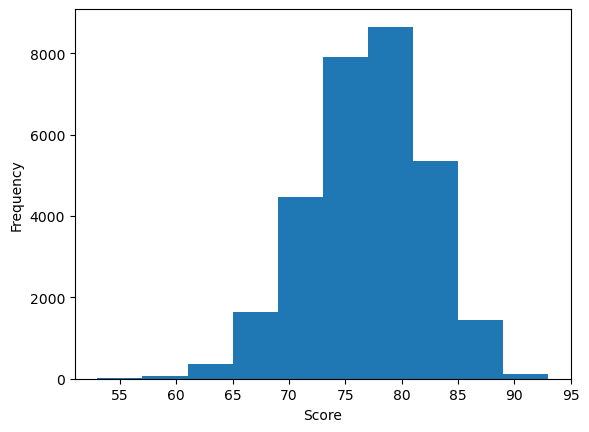

In [8]:
plt.hist(df['score'])
plt.xlabel('Score')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

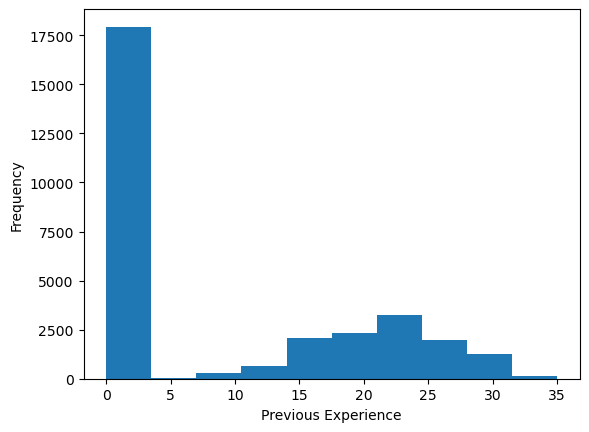

In [9]:
plt.hist(df['previous_exp'])
plt.xlabel('Previous Experience')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

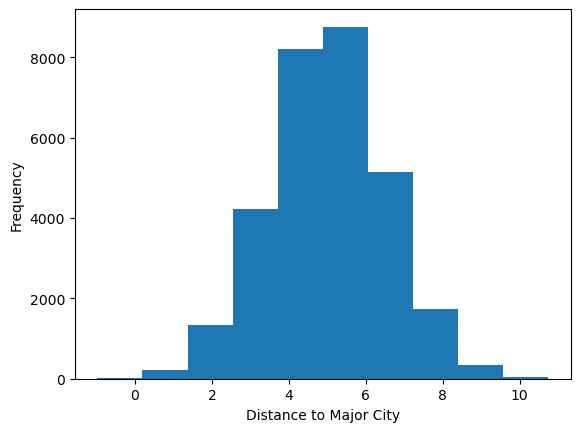

In [10]:
plt.hist(df['distance_majorcity'])
plt.xlabel('Distance to Major City')
plt.ylabel('Frequency')

### Randomized Control Trial

In [22]:
RCT = data
place_treat = RCT.filter(pl.col('treatment') == 1).select('placement')
place_control = RCT.filter(pl.col('treatment') == 0).select('placement')

In [25]:
t_stat, p_value = stats.ttest_ind(place_treat, place_control)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: [29.70663666], P-value: [3.71927462e-191]


Proportion Tables

In [33]:
contingency_table = pd.crosstab(RCT['treatment'], RCT['placement'])

print(contingency_table)

col_0      0     1
row_0             
0      12372  2660
1      10128  4840


In [34]:
# Proportion table (cell proportions)
proportion_table = contingency_table / contingency_table.sum().sum()

print(proportion_table)

col_0       0         1
row_0                  
0      0.4124  0.088667
1      0.3376  0.161333


### Logistic Regression

In [39]:
RCT = df.to_dummies('gender')
RCT = RCT.drop('gender_F')

In [40]:
X_train, X_test, y_train, y_test = train_test_split(RCT.drop('placement'), RCT['placement'], test_size=0.25, random_state=2059)

In [41]:
logit = LogisticRegression()
logit.fit(X_train, y_train)

c:\Users\meala\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [53]:
{'Intercept': logit.intercept_[0], 
              **{X_train.columns[i]: logit.coef_[0][i] for i in range(len(X_train.columns))}}


{'Intercept': -12.328646782527006,
 'treatment': 2.2245052533071177,
 'age': -1.4346199309791574,
 'score': 0.363050500482606,
 'gender_M': -0.4655966558399301,
 'experience': 1.4929678915624522,
 'previous_exp': 0.243481991171138,
 'distance_majorcity': 1.1237465825657837,
 'owns_motor': 1.6349792663864777}

In [62]:
logit.score(X_test, y_test)

0.8981333333333333

### Two Model Uplift

In [63]:
treatment = RCT.filter(pl.col('treatment') == 1)
control = RCT.filter(pl.col('treatment') == 0)

In [64]:
lr_treat = LogisticRegression()
lr_control = LogisticRegression()

In [66]:
lr_treat.fit(treatment.drop('placement'), treatment['placement'])

c:\Users\meala\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()